In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from datetime import datetime

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [47]:
train = pd.read_csv('fog_train.csv', index_col=0).rename(columns=lambda x: x.split('.')[1])
test = pd.read_csv('fog_test.csv', index_col=0).rename(columns=lambda x: x.split('.')[1])

In [55]:
# 클래스별 비율 확인
np.round(
    train['class'].value_counts(normalize=True).to_frame().reset_index().sort_values('index').set_index('index') * 100
, 3).astype(str) + '%'

,class
index,
-99,0.713%
1,0.249%
2,0.383%
3,0.386%
4,98.269%


In [56]:
np.round(
    train['class'].replace(-99, np.nan).replace(-99.9, np.nan)\
    .value_counts(normalize=True).to_frame().reset_index().sort_values('index').set_index('index') * 100
, 3).astype(str) + '%'

,class
index,
1.0,0.251%
2.0,0.386%
3.0,0.389%
4.0,98.975%


In [58]:
np.round(
    train['class'].replace(-99, np.nan).replace(-99.9, np.nan)\
    .value_counts().to_frame().reset_index().sort_values('index').set_index('index')
, 3)

,class
index,
1.0,7866
2.0,12088
3.0,12180
4.0,3101809


In [31]:
# 지역 처리
train['stn_group'] = train['stn_id'].str[0]
train['stn_group_binary'] = train['stn_group'].map({'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5})

test['stn_group'] = test['stn_id'].str[0]
test['stn_group_binary'] = test['stn_group'].map({'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5})

In [34]:
# 안 쓰는 컬럼 drop
drop_columns = ['year', 'month', 'day', 'time', 'minute'] + ['stn_id', 'stn_group']

# train에서 class가 -99인 데이터(결측치) drop
train['class'] = train['class'].replace(-99, np.nan).replace(-99.9, np.nan) - 1

train_drop = train.dropna().drop(drop_columns, axis=1).drop('vis1', axis=1).reset_index(drop=True)
test_drop = test.drop(drop_columns, axis=1).reset_index(drop=True)

train_drop.shape, test_drop.shape

((3133943, 9), (262800, 9))

In [35]:
X = train_drop.drop('class', axis=1)
y = train_drop['class']

X_test = test_drop

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, train_size=0.75)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((2350457, 8), (783486, 8), (2350457,), (783486,))

In [36]:
from sklearn.metrics import make_scorer

def grid_csi_index(y_true, y_pred):
    
    model_cm = confusion_matrix(y_true, y_pred)

    H = (model_cm[0][0] + model_cm[1][1] + model_cm[2][2])
    F = (model_cm[0][1] + model_cm[0][2] + 
            model_cm[1][0] + model_cm[1][2] + 
            model_cm[2][0] + model_cm[2][1] +
            model_cm[3][0] + model_cm[3][1] + model_cm[3][2])
    M = (model_cm[0][3] + model_cm[1][3] + model_cm[2][3])

    model_csi = H / (H + F + M)

    return model_csi

custom_scorer = make_scorer(grid_csi_index)

In [60]:
models = {
    'XGBoost': XGBClassifier(tree_method='hist', device='cuda', random_state=42),
    'LightGBM': LGBMClassifier(verbosity=-1, device='gpu', random_state=42)
}

model_results = {}
confusion_matrixes = {}

for name, model in models.items():
    start_time = datetime.now()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    csi = grid_csi_index(y_val, y_pred)
    accuracy = accuracy_score(y_val, y_pred)
#     precision = precision_score(y_val, y_pred)
#     recall = recall_score(y_val, y_pred)
#     f1 = f1_score(y_val, y_pred)
    model_results[name] = csi
    confusion_matrixes[name] = confusion_matrix(y_val, y_pred)
    time_delta = datetime.now() - start_time
    with open(f'''{name}(튜닝X)_{start_time.strftime('%Y%m%d%H%M%S')}.pkl''', 'wb') as file:
        pickle.dump(model, file)
    print(f"{name} 학습 완료! CSI: {np.round(csi, 5)}, Accuracy: {np.round(accuracy, 5)}, 학습 시간: {time_delta.seconds}.{time_delta.microseconds // 10000}s")
#     print(f"{name} 학습 완료! CSI: {np.round(csi, 5)}, 정확도: {np.round(accuracy, 5)}, F1: {np.round(f1, 5)}, 학습 시간: {time_delta.seconds}.{time_delta.microseconds // 10000}s")
#     print(f"{name} 학습 완료! CSI: {np.round(csi, 5)}, Accuracy: {np.round(accuracy, 5)}, Recall: {np.round(recall, 5)}, Precision: {np.round(precision, 5)}, 학습 시간: {time_delta.seconds}.{time_delta.microseconds // 10000}s")

XGBoost 학습 완료! CSI: 0.04667, Accuracy: 0.99009, 학습 시간: 6.40s
LightGBM 학습 완료! CSI: 0.04923, Accuracy: 0.98753, 학습 시간: 10.77s


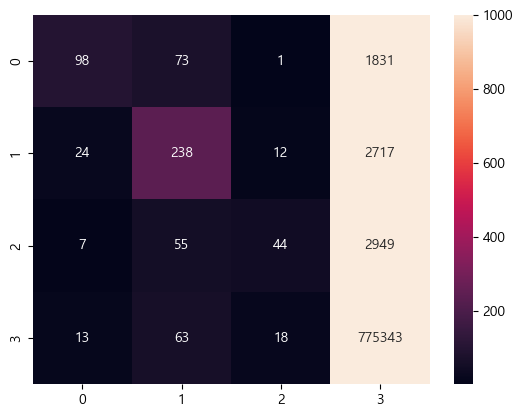

In [85]:
import seaborn as sns

sns.heatmap(
    pd.DataFrame(confusion_matrixes['XGBoost']),
    annot=True,
    vmax=1000,
    fmt=".0f"
)

plt.show()

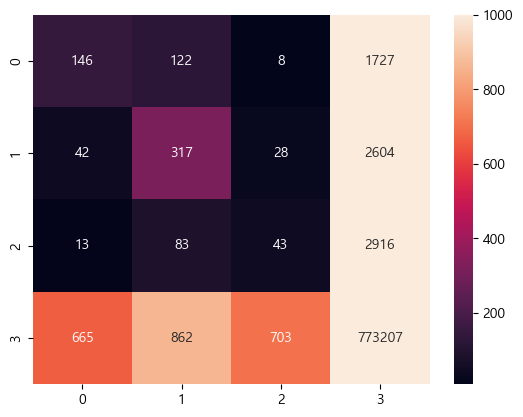

In [84]:
sns.heatmap(
    pd.DataFrame(confusion_matrixes['LightGBM']),
    annot=True,
    vmax=1000,
    fmt=".0f"
)

plt.show()